Dependencies

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [ ]:
!pip list

Limit GPU consumption

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
for gpu in gpus:
  print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Tesorflow dataset

In [5]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist',split="train")

In [7]:
ds.as_numpy_iterator().next()['label']

np.int64(2)

Visualize Data & Build Data

In [8]:
import numpy as np

In [9]:
dataiterator = ds.as_numpy_iterator()

Subplot formatting and get 4 images in a batch

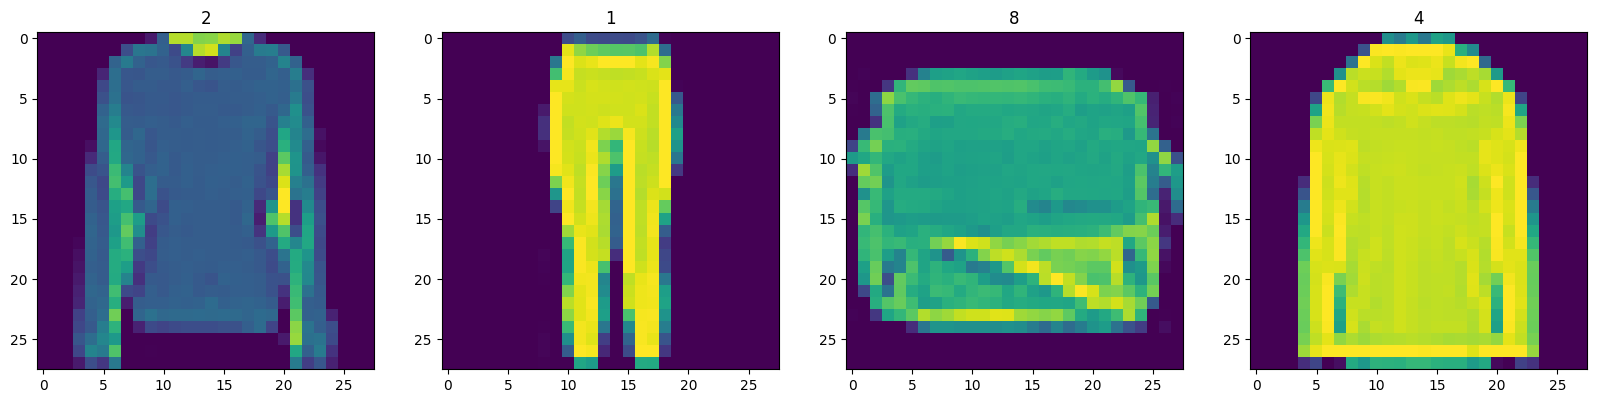

In [10]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

Scale and return Images

In [11]:
def scale_images(data):
  image = data['image']
  return image / 255

In [12]:
# Reload the dataset
ds = tfds.load('fashion_mnist',split="train")
# scale images
ds = ds.map(scale_images)
# Cache the dataset
ds = ds.cache()
# Shuffle the dataset
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces likelihood of bottlenecking
ds = ds.prefetch(64)

In [13]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

Neural Network

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Generator

In [75]:
def build_generator():
  model = Sequential()

  # takes the random values and reshapes it to 7*7*128
  model.add(Dense(7*7*128,input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))


  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

   # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(1,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

   # Convolutional block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv Layer to get to one channel
  model.add(Conv2D(1,4,padding="same",activation="sigmoid"))

  return model

In [76]:
generator = build_generator()

In [77]:
generator.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 1)      │         3,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 128)    │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,488,514 (5.68 MB)

 Trainable params: 1,488,514 (5.68 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
img = generator.predict(np.random.randn(4,128,1))
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[[[0.5001805 ],
         [0.5000959 ],
         [0.49999017],
         ...,
         [0.49937072],
         [0.4999416 ],
         [0.4997712 ]],

        [[0.50010276],
         [0.50048465],
         [0.5007698 ],
         ...,
         [0.49940977],
         [0.49947247],
         [0.4994407 ]],

        [[0.49982262],
         [0.5003558 ],
         [0.50038755],
         ...,
         [0.49924168],
         [0.4992778 ],
         [0.49899137]],

        ...,

        [[0.50046825],
         [0.50033945],
         [0.5000378 ],
         ...,
         [0.4998902 ],
         [0.50006145],
         [0.500036  ]],

        [[0.5001402 ],
         [0.50017035],
         [0.50010407],
         ...,
         [0.49944547],
         [0.4995874 ],
         [0.49981898]],

        [[0.50015706],
         [0.50003195],
         [0.49970773],
         ...,
         [0.49993837],
         [0.49982494],
         [0.5000798 ]]],


       [[[0.50019366],
         [0.5001476 ],
         [0.50

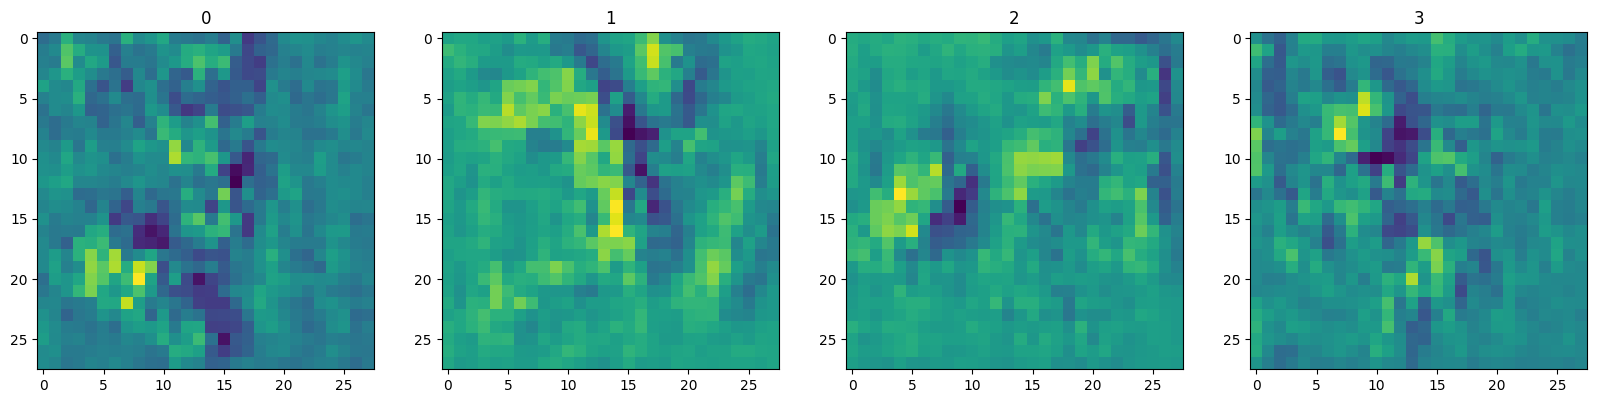

In [19]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(img):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

Build Discriminator

In [20]:
def build_discriminator():
  model = Sequential()

  # Conv Block 1
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv Block 2
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv Block 3
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv Block 4
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation="sigmoid"))

  return model

In [21]:
discriminator = build_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
img.shape

(4, 28, 28, 1)

In [28]:
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


array([[0.4903374 ],
       [0.49031317],
       [0.49033913],
       [0.49034858]], dtype=float32)

Construct Training Loop

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [30]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [31]:
from tensorflow.keras.models import Model

In [44]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)

    # create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator


  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    #Complie with base class
    super().compile(*args, **kwargs)

    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    #Get Data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)),training=False)

    #Train the discriminator
    with tf.GradientTape() as d_tape:
      #Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images,training=True)
      yhat_fake = self.discriminator(fake_images,training=True)
      yhat_realfake = tf.concat([yhat_real,yhat_fake],axis=0)

      #Create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)],axis=0)

      #Add some noise to the TRUE output
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real,noise_fake],axis=0)

      #Calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    #Apply backpropagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


    #Train the generator
    with tf.GradientTape() as g_tape:
      #Generate some new images
      gen_images = self.generator(tf.random.normal((128,128,1)),training=True)

      #Create the predicted lables
      predicted_labels = self.discriminator(gen_images,training=False)

      #Calculate loss - trick to training to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

    #Apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))


    return {"d_loss":total_d_loss,"g_loss":total_g_loss}


In [45]:
#Instance
fashgan = FashionGAN(generator,discriminator)

In [46]:
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

Callback

In [41]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

Train

In [47]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [59]:
pwd

'/content'

In [ ]:
#2000 epochs Recommended
hist = fashgan.fit(ds,epochs=30,callbacks=[ModelMonitor()])

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 106ms/step - d_loss: 0.6885 - g_loss: 0.6638
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - d_loss: 0.6849 - g_loss: 0.6666
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - d_loss: 0.6718 - g_loss: 0.7289


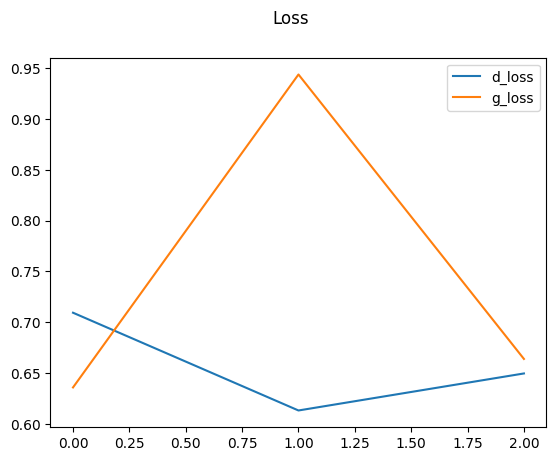

In [62]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

Test Out the Generator

Generate Images

In [82]:
ls

images/  sample_data/  weights/


In [90]:
#Use the weights or the model after the training

In [70]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')